In this notebook, I design a day trading tool using linear programming and stock price forecasts from the regression model ('1.stock_prediction.ipynb'). I simulate and test the algorithm assuming that I start trading on Day 505 with $1M and monetize all the stocks by the end of Day 756.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from gurobipy import Model, GRB

start_time = datetime.now()
sns.set()

C:\Users\jkim\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Loading

In [2]:
stocklist = ['SH600000', 'SH600010', 'SH600015', 'SH600016', 'SH600018', 'SH600028', 'SH600030', 'SH600036', 'SH600048', 'SH600050', 'SH600089', 'SH600104', 'SH600109', 'SH600111', 'SH600150', 'SH600256', 'SH600406', 'SH600518', 'SH600519', 'SH600583', 'SH600585', 'SH600637', 'SH600690', 'SH600837', 'SH600887', 'SH600893', 'SH600958', 'SH600999', 'SH601006', 'SH601088', 'SH601166', 'SH601169', 'SH601186', 'SH601288', 'SH601318', 'SH601328', 'SH601390', 'SH601398', 'SH601601', 'SH601628', 'SH601668', 'SH601688', 'SH601766', 'SH601800', 'SH601818', 'SH601857', 'SH601901', 'SH601988', 'SH601989', 'SH601998']

In [3]:
pred = pd.read_csv('prediction.csv', index_col=0)
actual = pd.read_csv('actual.csv', index_col=0)
model = pd.read_csv('summary.csv', index_col=0)
risk = pd.read_csv('risk.csv', index_col=0)

In [4]:
pred

,SH600000,SH600010,SH600015,SH600016,SH600018,SH600028,SH600030,SH600036,SH600048,SH600050,...,SH601668,SH601688,SH601766,SH601800,SH601818,SH601857,SH601901,SH601988,SH601989,SH601998
0,133.065762,13.188836,33.077128,146.935948,7.496075,17.184814,91.690054,137.896228,263.476713,8.329123,...,10.943376,20.391517,11.370145,15.120545,5.286700,10.104458,5.550787,6.212190,7.222601,7.959835
1,130.915916,13.077081,32.481859,145.636007,7.310952,17.067698,90.276124,135.698203,256.011470,8.215530,...,10.948292,19.695165,11.204548,15.029402,5.236627,10.101391,5.385873,6.183424,7.085806,7.909453
2,132.503395,13.104292,32.362408,145.082964,7.329455,17.291395,90.940672,135.645251,256.147992,8.247011,...,11.212752,19.802044,11.150279,15.267561,5.262544,10.119821,5.403790,6.227322,7.097424,7.934178
3,130.296729,13.028829,32.303642,143.385708,7.318140,16.830474,94.180925,133.890497,246.593157,8.207685,...,11.015776,19.368934,11.047136,15.025818,5.212534,10.011938,5.359821,6.196970,7.085654,7.867482
4,129.955491,12.947011,32.104803,142.737749,7.323815,16.374901,94.650983,128.660477,246.283132,8.171876,...,11.057330,19.070328,10.966420,14.994416,5.198770,9.829419,5.306408,6.181838,7.006669,7.843109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,157.414982,11.109810,33.676578,162.768558,8.218981,15.818557,128.389059,184.618474,324.655616,9.280964,...,10.008642,22.748316,8.705592,11.313637,6.344367,8.003320,7.306884,6.670574,8.635478,9.147226
248,157.519605,11.046475,33.540901,162.735982,8.166477,15.792161,127.876162,183.486560,327.513639,9.282170,...,9.996132,22.753745,8.666583,11.062474,6.277909,7.987651,8.009950,6.689816,8.571891,9.061407
249,154.835775,10.802116,33.173019,161.470949,7.979429,15.599536,125.280331,182.931683,319.562978,9.166284,...,9.760108,22.214350,8.538862,10.769028,6.224024,7.879030,8.343596,6.638727,8.428950,9.019260
250,155.647449,10.913195,33.330717,161.704658,7.989161,15.702994,125.280679,185.506095,315.082613,9.147299,...,9.800497,22.574935,8.534850,10.802430,6.209669,7.881728,8.140544,6.638727,8.449833,9.020426


In [5]:
actual

,SH600000,SH600010,SH600015,SH600016,SH600018,SH600028,SH600030,SH600036,SH600048,SH600050,...,SH601668,SH601688,SH601766,SH601800,SH601818,SH601857,SH601901,SH601988,SH601989,SH601998
0,131.0422,13.0376,32.4801,145.4577,7.2766,17.0232,89.7523,135.4195,256.1322,8.1916,...,10.9538,19.6981,11.1686,15.0431,5.2333,10.0654,5.3911,6.1756,7.0863,7.8668
1,133.0164,13.1211,32.3516,144.7243,7.3176,17.2544,91.0476,135.2283,256.1322,8.2229,...,11.2201,19.8139,11.1449,15.2742,5.2608,10.1047,5.4221,6.2273,7.1200,7.8952
2,130.4252,13.0376,32.3087,143.0130,7.2902,16.7920,94.1239,133.4118,246.8721,8.1916,...,11.0603,19.3620,11.0262,15.0674,5.2058,9.9869,5.3808,6.1928,7.1200,7.8243
3,130.0550,12.9540,32.0945,142.2796,7.2902,16.3295,94.9874,127.9626,245.4929,8.1447,...,11.0425,19.0608,10.9550,15.0066,5.1921,9.7774,5.3291,6.1756,7.0526,7.7960
4,126.4767,12.9540,31.8374,140.8128,7.3313,16.2139,94.1779,123.8517,243.7197,8.0666,...,10.4034,19.2230,10.7888,14.4350,5.0822,9.7251,5.3704,6.1411,6.9853,7.7109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,158.0162,11.0800,33.5002,162.7318,8.1519,15.6655,129.2350,184.2688,328.1806,9.2722,...,9.9581,22.8111,8.6001,11.1554,6.3388,7.7857,8.0981,6.7003,8.8836,9.0826
248,155.2172,10.8281,33.1494,161.4403,7.9562,15.4794,126.3303,183.5816,320.7965,9.1461,...,9.7389,22.2461,8.4668,10.8576,6.2816,7.6648,8.3988,6.6460,8.7487,9.0383
249,156.2351,10.9960,33.2809,161.6986,7.9702,15.5725,127.0427,186.5759,316.0789,9.1461,...,9.7571,22.6463,8.4789,10.8700,6.2673,7.6917,8.2225,6.6460,8.7993,9.0383
250,155.7262,10.9121,33.1055,160.9237,7.9282,15.5414,126.7687,185.4960,313.8227,9.1776,...,9.7754,22.6110,8.4426,10.7583,6.2529,7.6783,8.1396,6.6279,8.7656,8.9941


In [6]:
model.head()

,best_model,MSE_train,R2_train,MSE_test,R2_test,MSE_oot,R2_oot
SH600000,Lasso,2.930437,0.964453,3.020212,0.923013,3.793888,0.965153
SH600010,Lasso,0.113562,0.979846,0.083943,0.608555,0.078977,0.965122
SH600015,Lasso,0.178823,0.951984,0.246179,0.775781,0.127715,0.937652
SH600016,Lasso,2.897718,0.965544,3.443620,0.829596,1.964804,0.952426
SH600018,Lasso,0.027129,0.975772,0.016841,0.912410,0.059537,0.959942


In [7]:
model['RMSE_test'] = np.sqrt(model['MSE_test'])
model['RMSE_test'].describe()

count     50.000000
mean       5.532727
std       17.341578
min        0.070739
25%        0.194695
50%        0.561703
75%        2.946182
max      110.959773
Name: RMSE_test, dtype: float64

In [8]:
risk

,SH600000,SH600010,SH600015,SH600016,SH600018,SH600028,SH600030,SH600036,SH600048,SH600050,...,SH601668,SH601688,SH601766,SH601800,SH601818,SH601857,SH601901,SH601988,SH601989,SH601998
0,0.013615,0.021215,0.013253,0.011593,0.015898,0.016501,0.020659,0.019538,0.028045,0.021142,...,0.017720,0.023931,0.019219,0.023413,0.012277,0.016533,0.022239,0.011049,0.015905,0.013913
1,0.013271,0.021219,0.013118,0.011347,0.015903,0.016533,0.020682,0.019415,0.027991,0.020570,...,0.017810,0.023423,0.019220,0.023440,0.012283,0.016408,0.021675,0.011036,0.015100,0.013915
2,0.013333,0.021206,0.013113,0.011377,0.015835,0.016524,0.020748,0.019214,0.028082,0.020565,...,0.017797,0.023483,0.019197,0.023455,0.012151,0.016414,0.021656,0.010793,0.015070,0.013479
3,0.013334,0.021203,0.013119,0.011374,0.015704,0.016649,0.020685,0.019430,0.028083,0.020457,...,0.017796,0.023464,0.019170,0.023447,0.012147,0.016484,0.021628,0.010789,0.014864,0.013478
4,0.013484,0.021198,0.013131,0.011397,0.015707,0.016491,0.020651,0.019576,0.028089,0.020421,...,0.018297,0.023462,0.019163,0.023613,0.012248,0.016388,0.021637,0.010795,0.014805,0.013500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,0.012198,0.017765,0.008903,0.007597,0.026504,0.008497,0.020056,0.014853,0.018742,0.018573,...,0.012992,0.021177,0.010909,0.018092,0.013895,0.007816,0.020974,0.007487,0.022352,0.010861
248,0.012167,0.017565,0.008809,0.007439,0.026331,0.008435,0.020123,0.014520,0.018225,0.018507,...,0.012933,0.020719,0.010959,0.018055,0.013796,0.007796,0.020593,0.007417,0.021729,0.010591
249,0.012133,0.017422,0.008621,0.007307,0.026304,0.008343,0.019090,0.014563,0.018129,0.018382,...,0.012846,0.020732,0.010880,0.018012,0.013758,0.007741,0.020645,0.007322,0.020409,0.010511
250,0.012136,0.017419,0.008614,0.007315,0.026303,0.008336,0.019030,0.014547,0.018097,0.018381,...,0.012835,0.020706,0.010876,0.018022,0.013758,0.007739,0.020620,0.007325,0.020399,0.010507


## Buy and Hold strategy

In order to give a little context to the trading algorithm and have a baseline for comparison, I first implement a buy and hold strategy with each of the 50 stocks over days 505-756. The following is the summary of results in %:

In [9]:
return_buynhold = 100*(actual.iloc[-1,:]-actual.iloc[0,:])/actual.iloc[0,:]
return_buynhold.describe()

count    50.000000
mean     15.174534
std      29.144297
min     -64.561553
25%      -3.999649
50%      13.818788
75%      29.583321
max      94.264119
dtype: float64

In [10]:
return_buynhold[return_buynhold==return_buynhold.max()]

SH600519    94.264119
dtype: float64

In [11]:
return_buynhold[return_buynhold==return_buynhold.min()]

SH600518   -64.561553
dtype: float64

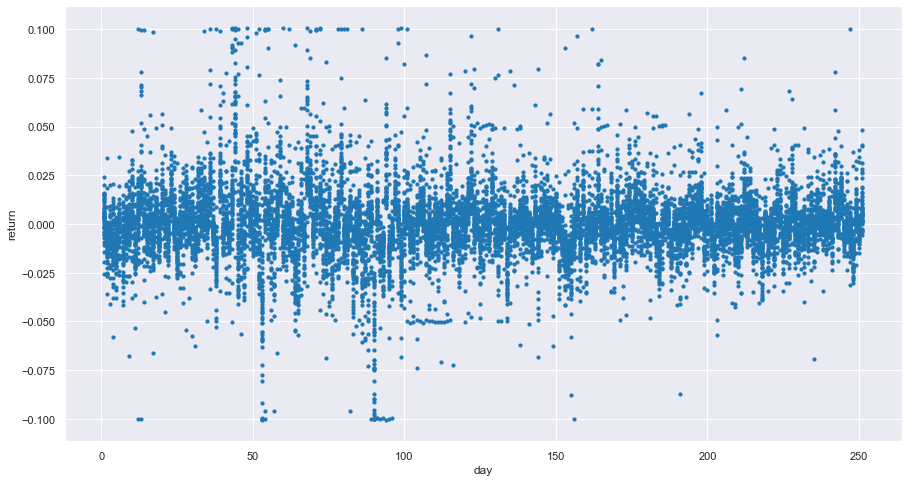

In [12]:
# Daily stock return plot
temp = (actual/actual.shift(1)-1).dropna()

plt.figure(figsize = (15, 8))

for col in temp.columns:
    plt.scatter(x=temp.index, y=temp[col], color='tab:blue', s=10)

plt.xlabel('day')
plt.ylabel('return')
plt.show()

## Linear Optimization (Gurobi)

Here are some assumptions for this project instructed by the professor:
- We take a no short sale rule (a short sale is the sale of an asset or stock the seller does not own) for this project which most large mutual funds also enforce. 
- To simplify things, assume that we buy and sell each stock at the daily closing price.
- We take the t + 1 rule, which means if we buy a share of stock A at time t, we can only sell it at t + 1.
- We assume that whenever we decide to buy or sell a certain number of shares, we have a counterparty to engage in the transaction.

**Abstract Formulation**

***Data***
- $J$: set of stocks
- $\text{actual}_{j}$: actual close price of each stock $j$ for today
- $\text{pred}_{j}$ predicted close price of each stock $j$ for tomorrow based on the regression model
- $\text{risk}_{j}$: 180-day volatility of each stock $j$ based on today 
- $\text{riskavg}$: average 180-day volatility of all stocks based on today
- $\text{RMSE}_{j}$: root mean sqaure error of each stock $j$ from the test dataset based on the regression model
- $\text{cash}$: cash from yesterday
- $\text{stock_qty}_{j}$: quantity in possession for each stock $j$ based on yesterday

***Decision Variables***
- $\text{buy}_{j}$: how much quantity to buy stock $j$ today
- $\text{sell}_{j}$: how much quantity to sell stock $j$ today
- $\text{cf}_{k}$: cash flow at time $k \in \{0,1\}$ (0: today / 1: tomorrow)

***Formulation***
$$\begin{aligned}
\text{Maximize:} && &\text{cf}_{1} && \text{(Cashflow tomorrow)}\\
\\
\text{subject to:} \\
\text{(Cashflow today)} && \text{cf}_{0} & = \text{cash} + \sum_{j \in J}\text{sell}_{j}\text{actual}_{j}(1-0.00065) - \sum_{j \in J}\text{buy}_{j}\text{actual}_{j}(1+0.00065) && \text{for each stock $j \in J$}\\
\text{(Cashflow tomorrow)} && \text{cf}_{1} &= \text{cf}_{0} + \sum_{j \in J}\text{buy}_{j}\text{pred}_{j}(1-0.00065) && \text{for each stock $j \in J$}\\
\text{(Risk)} && \sum_{j \in J}\text{risk}_{j}\text{buy}_{j} &\le \text{riskavg}\sum_{j \in J}\text{buy}_{j} && \text{for each stock $j \in J$} \\
\text{(RMSE)} && \sum_{j \in J}\text{RMSE}_{j}\text{buy}_{j} &\le 0.1\sum_{j \in J}\text{buy}_{j}\text{actual}_{j}(1+0.00065) && \text{for each stock $j \in J$} \\
\text{(Quantity)} && \text{sell}_{j} &\le \text{stock_qty}_{j} && \text{for each stock $j \in J$} \\
\end{aligned}$$

***Note***
- 0.00065 refers to a transaction cost from stamp duty and slippage. The stamp duty is the government’s tax when you trade stock, and we assume it is 0.1% for a buy and sell roundtrip. The slippage refers to the difference between the expected execution price of an order and the actual execution price, and we take the value of 0.03% for a roundtrip. Together, the total transaction cost is 0.13% for a roundtrip and 0.065% for single trade action.
- Risk constraint infers that the weighted average of our portfolio's volatility should be lower than the average volatility of the market.
- RMSE constraint infers that the maximum loss due to the prediction errors we can endure is 10% of our daily investment.
- This optimization tool is for day trading, which means we have to run it every day.

In [13]:
J = pred.columns
stock_qty = pd.DataFrame(np.zeros((1,50)), columns=J)
cash=[1000000]

for day in pred.index[:-1]:
    mod=Model()
    
    buy = mod.addVars(J, lb=0, vtype=GRB.INTEGER) # buy quantity
    sell = mod.addVars(J, lb=0, vtype=GRB.INTEGER) # sell quantity
    cf = mod.addVars(range(2), lb=0)

    mod.setObjective(cf[1], sense=GRB.MAXIMIZE) # maximize tomorrow's cashflow
    
    mod.addConstr(cf[0] == cash[day]+sum(sell[j]*actual.loc[day,j]*(1-0.00065) for j in J)-sum(buy[j]*actual.loc[day,j]*(1+0.00065) for j in J)) # cashflow today
    mod.addConstr(cf[1] == cf[0]+sum(buy[j]*pred.loc[day+1,j]*(1-0.00065) for j in J)) # cashflow tomorrow
    mod.addConstr(sum(risk.loc[day,j]*buy[j] for j in J) <= risk.loc[day,:].mean()*sum(buy[j] for j in J)) # risk constraint
    mod.addConstr(sum(model.loc[j,'RMSE_test']*buy[j] for j in J) <= sum(buy[j]*actual.loc[day,j]*(1+0.00065) for j in J)*0.1) # RMSE constraint
    
    for j in J: 
        mod.addConstr(sell[j] <= stock_qty.loc[day,j]) # quantity constraint
        
    mod.setParam('outputflag', False)
    mod.optimize()

    for j in J:    
        stock_qty.loc[day+1,j] = int(stock_qty.loc[day,j]-sell[j].x+buy[j].x)
    cash.append(cf[0].x) 

Using license file C:\Users\jkim\gurobi.lic
Academic license - for non-commercial use only


In [14]:
pd.set_option('display.max_columns', None)
stock_qty.iloc[1:,:]

,SH600000,SH600010,SH600015,SH600016,SH600018,SH600028,SH600030,SH600036,SH600048,SH600050,SH600089,SH600104,SH600109,SH600111,SH600150,SH600256,SH600406,SH600518,SH600519,SH600583,SH600585,SH600637,SH600690,SH600837,SH600887,SH600893,SH600958,SH600999,SH601006,SH601088,SH601166,SH601169,SH601186,SH601288,SH601318,SH601328,SH601390,SH601398,SH601601,SH601628,SH601668,SH601688,SH601766,SH601800,SH601818,SH601857,SH601901,SH601988,SH601989,SH601998
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17814.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,28513.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21375.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18854.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,4529.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2116.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1408.0
5,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,1.0,0.0,0.0,544.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,1.0,0.0,0.0,0.0,736.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4408.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69302.0,0.0,0.0,0.0,0.0
248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,162909.0,0.0,0.0,0.0,0.0
249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,162697.0,0.0,0.0,0.0,0.0
250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,162486.0,0.0,0.0,0.0,0.0


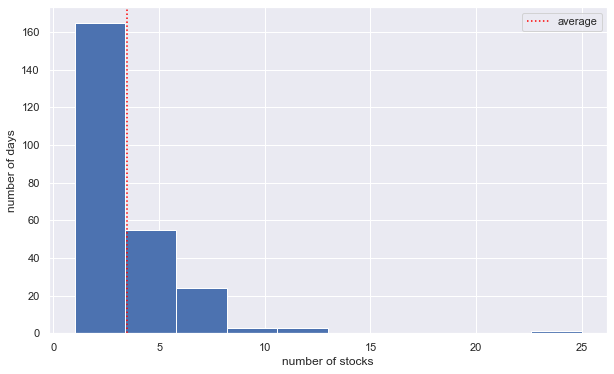

In [15]:
# Plot for the number of stocks possessed
plt.figure(figsize=(10,6))
plt.hist((stock_qty.iloc[1:,:]>0).sum(axis=1))
plt.axvline(x=(stock_qty.iloc[1:,:]>0).sum(axis=1).mean(), color='red', linestyle=':', label='average')
plt.legend()
plt.xlabel('number of stocks')
plt.ylabel('number of days')
plt.show()

For evaluation metrics, I look at the final return, Sharpe ratio and the number of days with profit. According to Investopedia, the Sharpe ratio was developed by Nobel laureate William F. Sharpe and is used to help investors understand the return of an investment strategy compared to its risk (https://www.investopedia.com/terms/s/sharperatio.asp). Here, I set the risk free rate to zero and use the following formula: 
$$ \text{sharpe_ratio} = \frac{\sqrt{252}*mean(pnl)}{stdev(pnl)} $$
where
$$ pnl = \frac{\text{total asset}(t)}{\text{total asset}(t-1)}-1 $$
$$ \text{total asset}(t) = \text{cash}(t) + \text{holding stock value}(t) $$

In [16]:
total_asset = (stock_qty.iloc[1:,:].reset_index(drop=True)*actual.iloc[:-1,:]).sum(axis=1) + cash[1:]
final_asset = (stock_qty.iloc[-1]*actual.iloc[-1]*(1-0.00065)).sum() + cash[-1]
total_asset[251] = final_asset
pnl = ((total_asset-total_asset.shift(1))/total_asset.shift(1)).dropna()
sharpe_ratio = np.sqrt(252)*np.mean(pnl)/np.std(pnl)

profitday = sum(pnl>0)

print(f'final return: {round((final_asset/1000000-1)*100,2)}%, Sharpe ratio: {round(sharpe_ratio,2)}, number of days with profit: {profitday} days')

final return: 24.41%, Sharpe ratio: 0.75, number of days with profit: 118 days


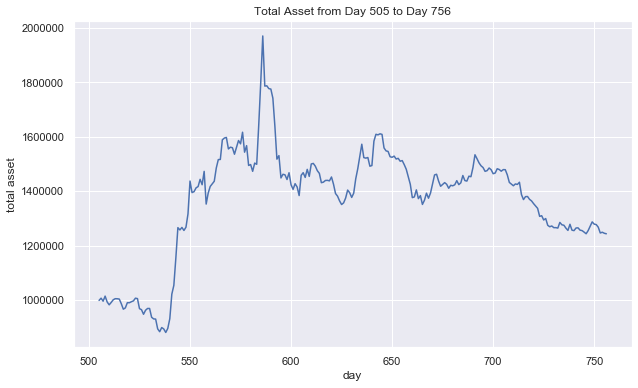

In [17]:
# Plot for total asset per day
total_asset.index = np.arange(505,757)
plt.figure(figsize=(10,6))
plt.plot(total_asset)
plt.xlabel('day')
plt.ylabel('total asset')
plt.title('Total Asset from Day 505 to Day 756')
plt.show()

**Conclusion**
- We can see that the linear programming with the final return of 24% is much better than the Buy and Hold strategy with the average return of 15%. 
- We also see an acceptable shape in terms of how our trading strategy performs from the plot above. While there are periods with a decrease in the total assets, the overall trend tends to be positive.
- Further improvements to our strategy could include an exploration into an even better prediction model. For example, we could find more data to engineer useful features or integrate classification models.

In [18]:
print(datetime.now()-start_time)

0:00:22.978399
